In [1]:
import copy
from pathlib import Path
import warnings
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pymysql

torch.__version__

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\danie\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


'1.10.2+cu102'

In [2]:
# Loads the data from the external database
dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
data = pd.read_sql("select * from summary order by timestamp desc limit 2000", dbcon) # Can remove/increase limit if enough GPU memory for CUDA, will increase accuracy
data.fillna(value = 0, inplace = True) # Replaces NoneType values with 0
data.replace(1.1e308, 0, inplace = True) # Replaces infinite values with 0
data = data[::-1]
data.reset_index(inplace=True, drop=True)

In [3]:
# Normalizes the data for use in the encoder
ts_data = pd.DataFrame()
cols = data.columns[1:]
sensor = []
timestamp = []
value = []
time_idx = []
ti = 0
for i in range(len(data["timestamp"])):
    for j in cols:
        timestamp.append(data["timestamp"][i])
        value.append(data[j][i])
        sensor.append(j)
        time_idx.append(ti)
    ti += 1
ts_data["timestamp"] = timestamp
ts_data["sensor"] = sensor
ts_data["value"] = value
ts_data["time_idx"] = time_idx
id = []
for i in range(len(ts_data)):
    id.append(i)
ts_data["id"] = id
# ts_data has 4 columns, timestamp, sensor, value, and time_idx
# There is a value for each sensor for each timestamp

# The below optionally removes all sensors which are inactive. This is reccomended to stop overfitting to inactive sensors which causes the predictions to ignore active ones
# If this is commented out, most predictions will lie at 0 as most sensors have an average value of 0 due to being inactive. Only comment this out if the majority of sensors are active
tmp = ts_data[ts_data["value"] != 0]
active_sensors = set(tmp["sensor"])
ts_data = ts_data[ts_data["sensor"].isin(active_sensors)]

In [4]:
# Sets up the initial parameters
max_prediction_length = int(len(ts_data)*0.4) # 60% training, 40% testing. Feel free to change this ratio if results are not as expected
max_encoder_length = 16
training_cutoff = ts_data["id"].max() - max_prediction_length

In [5]:
training = TimeSeriesDataSet(
    ts_data[lambda x: x.id <= training_cutoff], # Lambda function to select all data before the cutoff
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)

In [6]:
validation = TimeSeriesDataSet(
    ts_data[lambda x: x.id > training_cutoff], # Lambda function to select all data before the cutoff
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    predict_mode=True,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)

In [7]:
# Creates dataloaders for the model
batch_size = 8  # higher values increase accuracy at cost of CUDA memory
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0) # Num_workers can be increased on multi-core machines
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [8]:
# Calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_forecasting\data\timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


nan

In [9]:
# Configures the network and trainer for getting hyperparameter values
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=torch.cuda.device_count(), # Set to the amount of GPU's you want to use
    gradient_clip_val=0.1,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [10]:
# Creates the sample prediction function
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16, 
    attention_head_size=1, # Can be increased up to 4 for larger datasets
    dropout=0.1,  # Between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # Set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4, # Reduce learning rate if no improvement in validation loss after x epoch
)
#print(f"Number of parameters in network: {tft.size()/1e3:.1f}k") Uncomment to show number of parameters

In [11]:
# Find the optimal learning rate
torch.cuda.empty_cache()
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)
#print(f"suggested learning rate: {res.suggestion()}") Uncomment to show learning rate
# Plots learning rate to show optimal value
#fig = res.plot(show=True, suggest=True) Uncomment to plot learning rate

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:1079: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalcula

In [12]:
# Loads best study (see below)
try:
    with open("test_study.pkl", "rb") as fout:
        study = pickle.load(fout)
    keys = []
    values = []
    for i in study.best_trial.params.keys():
        keys.append(i)
    for i in study.best_trial.params.values():
        values.append(i)
except:
    print("Run the Optimizse Hyperparameters Cell")

In [13]:
# Configures the network and trainer
torch.cuda.empty_cache()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=values[keys.index("gradient_clip_val")],
    limit_train_batches=30,  # comment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
# Creates the prediction function
torch.cuda.empty_cache()
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=values[keys.index("learning_rate")],
    hidden_size=values[keys.index("hidden_size")],
    attention_head_size=values[keys.index("attention_head_size")],
    dropout=values[keys.index("dropout")],
    hidden_continuous_size=values[keys.index("hidden_continuous_size")],
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
#print(f"Number of parameters in network: {tft.size()/1e3:.1f}k") Uncomment to show number of parameters

In [15]:
# Fits the network
torch.cuda.empty_cache()
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 60    
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 402   
5  | encoder_variable_selection         | VariableSelecti

Global seed set to 42
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:428: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 24: 100%|██████████| 31/31 [00:12<00:00,  2.41it/s, loss=1.27, v_num=0, train_loss_step=0.871, val_loss=3.400, train_loss_epoch=1.470]


In [16]:
# Create a study of optimized hyperparameters - Check optuna_test folder for trial logs per epoch
# This takes a large amount of time to run so it is only really useful when re-training the model from scratch (can be 1 hour+ to fully optimize)
torch.cuda.empty_cache()
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200, #This can be increased to increase accuracy at the cost of execution speed
    max_epochs=30, # This can be increased to increase accuracy at the cost of execution speed
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

[I 2022-05-04 13:54:58,522] A new study created in memory with name: no-name-c9930d10-2cd3-479c-93c8-dc6aeaff7aa6
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TP

KeyError: 'val_loss'

In [ ]:
# Save study results so we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

In [17]:
# Show best hyperparameters
study.best_trial.params

{'gradient_clip_val': 0.09724443782599083,
 'hidden_size': 8,
 'dropout': 0.26819211867406834,
 'hidden_continuous_size': 8,
 'attention_head_size': 3,
 'learning_rate': 0.08170292594144293}

In [18]:
# Load the best model according to the validation loss (given that we use early stopping, this is not necessarily the last epoch)
torch.cuda.empty_cache()
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
with open("ts_model.pkl", "wb") as fout:
    pickle.dump(best_tft, fout)

In [19]:
# Calcualtes the mean absolute error on validation set
torch.cuda.empty_cache()
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
#(actuals - predictions).abs().mean()

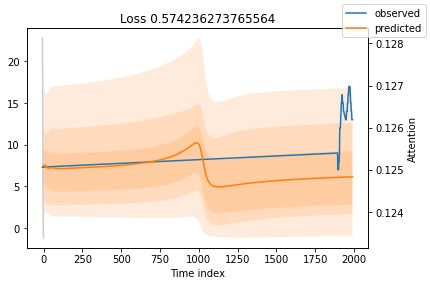

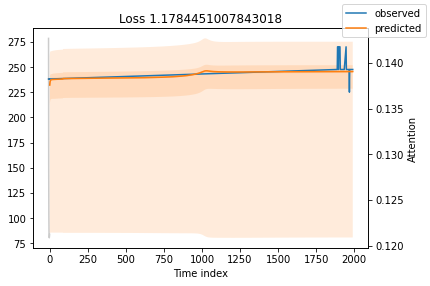

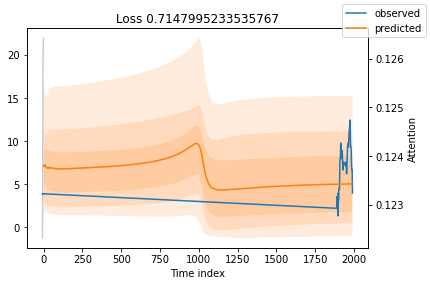

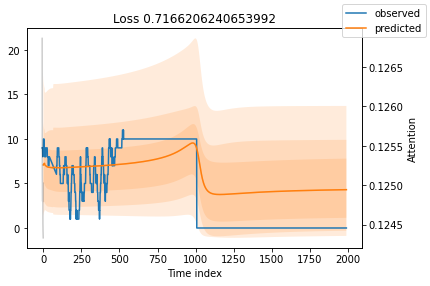

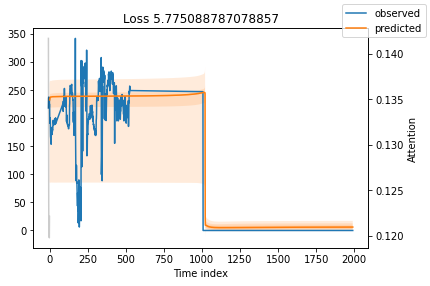

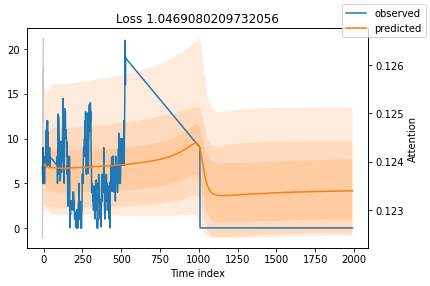

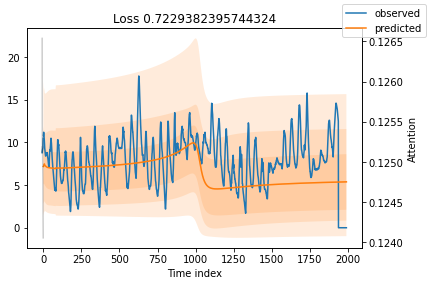

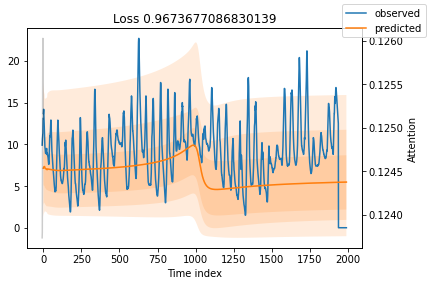

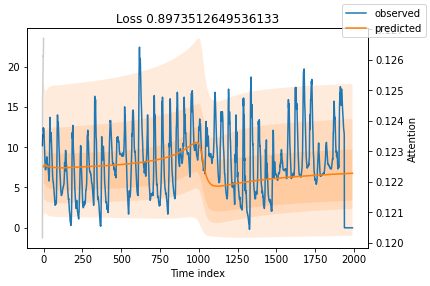

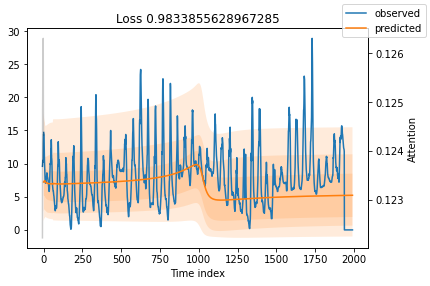

In [20]:
# Raw predictions are a dictionary from which all kind of information including quantiles can be extracted
# This is the only function that needs to be ran if you don't want to update the training, simply enter the data in the best_tft.predict method replacing val_dataloader
validation = TimeSeriesDataSet(
    ts_data, # No lambda function to select all data
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    predict_mode=True,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
torch.cuda.empty_cache()
try:
    with open("ts_model.pkl", "rb") as fout:
        best_tft = pickle.load(fout)
except:
    print("No model found")
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(len(active_sensors)):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'value': <Figure size 720x360 with 2 Axes>,
 'sensor': <Figure size 432x288 with 2 Axes>}

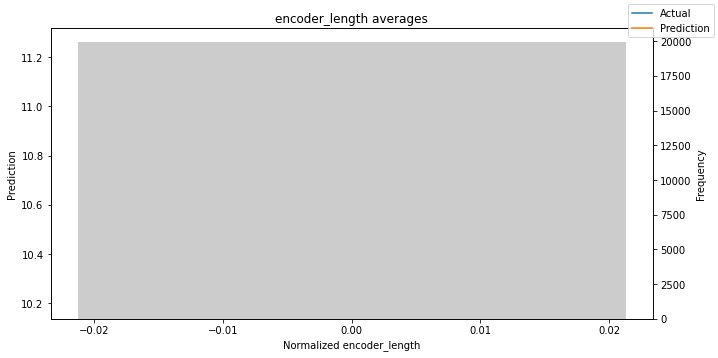

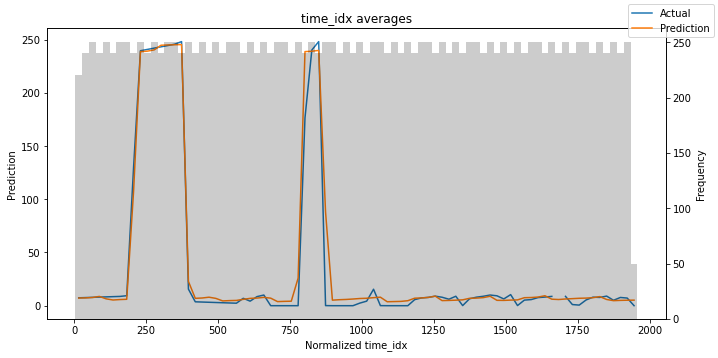

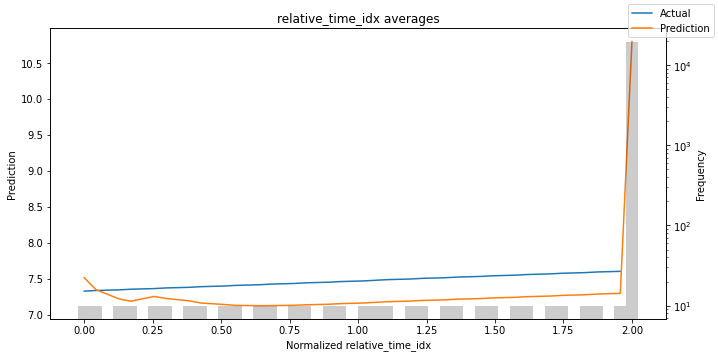

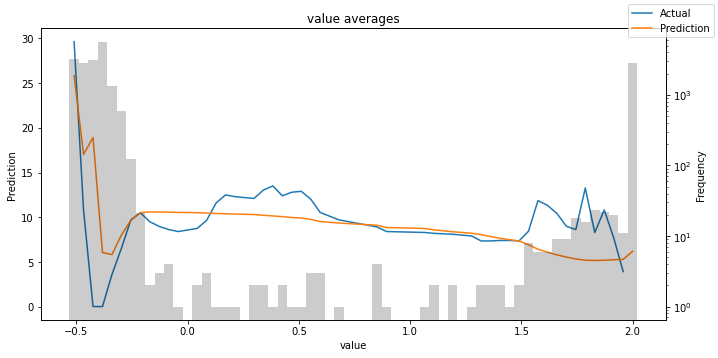

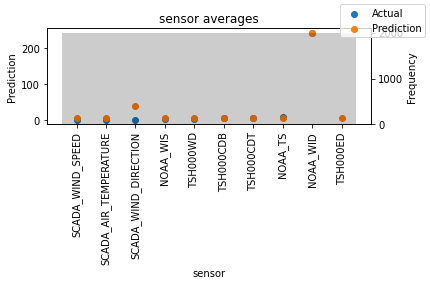

In [91]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

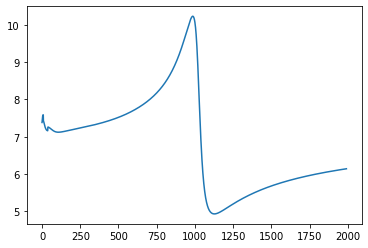

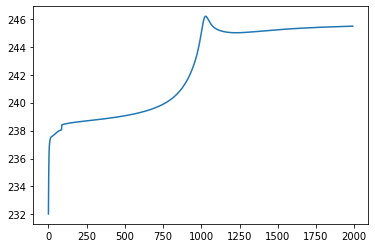

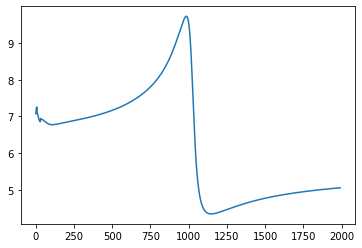

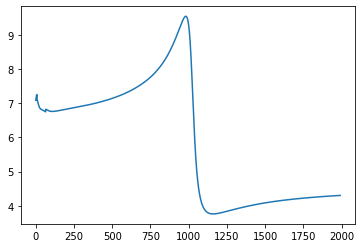

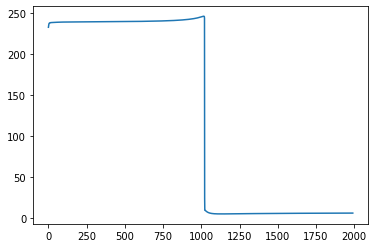

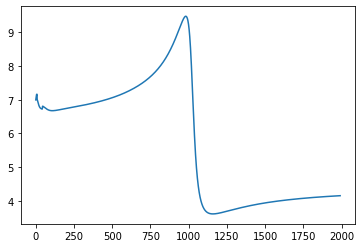

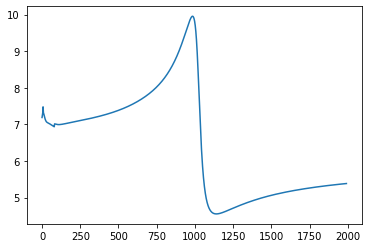

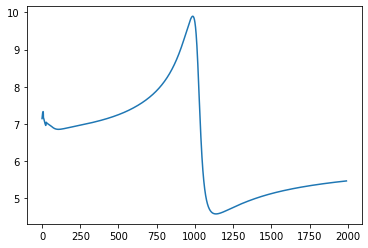

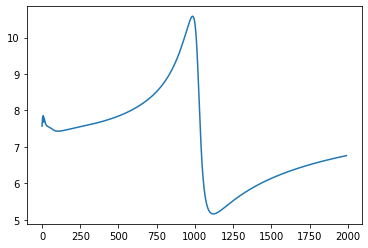

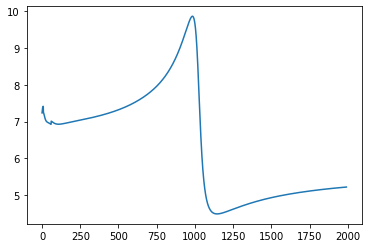

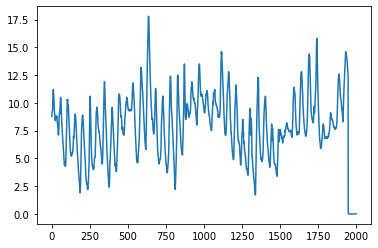

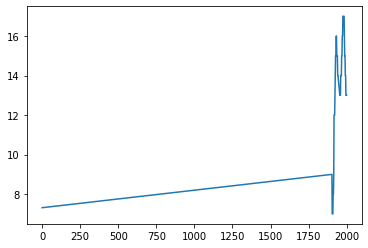

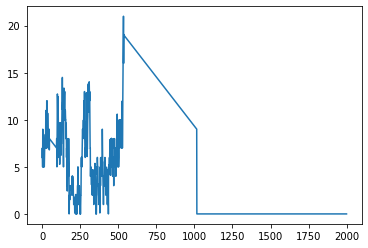

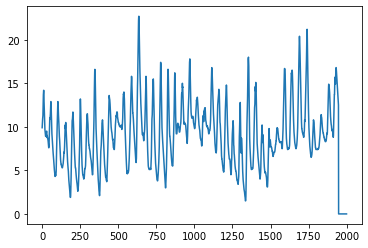

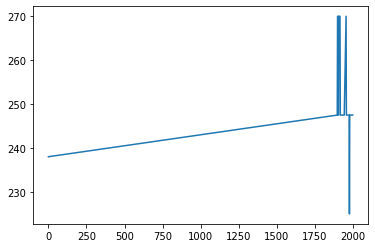

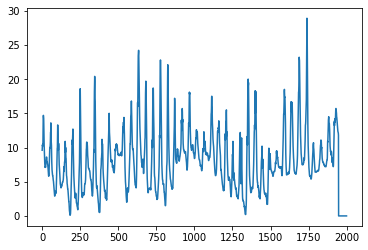

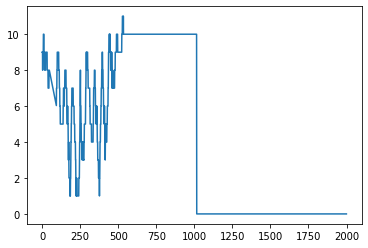

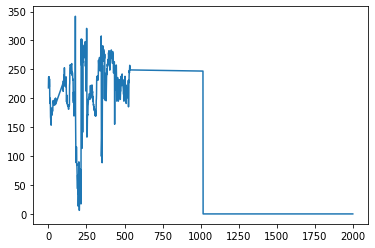

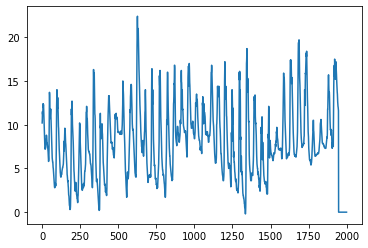

In [117]:
raw_predictions = best_tft.predict(val_dataloader, mode="prediction")
all_preds = []
for i in raw_predictions:
    preds = i.tolist()
    all_preds.append(preds)
all_vals = []
for j in range(len(active_sensors)-1):
    active_sensors = list(active_sensors)
    vals = ts_data.loc[ts_data["sensor"] == active_sensors[j]]
    tmp = []
    for i in vals["value"]:
        tmp.append(i)
    all_vals.append(tmp)
import matplotlib.pyplot as plt

### order of preds and vals doesn't match (i.e.: all_preds[0] matches all_vals[4] or some other value)
### also 10 predictions but only 9 sensors???
for i in all_preds:
    plt.figure()
    plt.plot(i)
for i in all_vals:
    plt.figure()
    plt.plot(i)
